In [0]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import col, count, mean, stddev, min, max, when, isnan, countDistinct, lit, to_timestamp, to_date, hour, avg, sum, date_sub, current_date, datediff, floor, row_number, date_format, weekofyear, year, round, substring, concat, regexp_replace, max as Fmax, lag, last, rank, unix_timestamp, to_timestamp, expr, when, udf
from pyspark.sql.functions import max as spark_max

from pyspark.sql.types import DoubleType

import seaborn as sns
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, NumericType, DateType, DoubleType
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.sql.window import Window
import matplotlib.pyplot  as plt 
from sklearn.metrics import roc_curve, auc
import builtins


In [0]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, StringType

from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import numpy as np 


In [0]:
app_name = "ml-training"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()

sc = spark.sparkContext

## Load Data  

In [0]:
train_data = spark.read.parquet("dbfs:/FileStore/tables/train_data3.parquet")
test_data = spark.read.parquet("dbfs:/FileStore/tables/test_data3.parquet")


# switch is_accident to label
train_data = train_data.withColumn("label", (col("is_accident") == 1).cast(IntegerType())).drop("is_accident")
test_data = test_data.withColumn("label", (col("is_accident") == 1).cast(IntegerType())).drop("is_accident")


In [0]:
# drop labelm id columns , and EDA feature 
drop_columns = ['zipcode',"trip_date"]

# drop 
drop_columns.extend(["year", "month"])

train_data = train_data.drop(*drop_columns)
test_data = test_data.drop(*drop_columns)

schema = train_data.schema

In [0]:
# find non-numerical columns
numerical_cols = [field.name for field in schema if isinstance(field.dataType, NumericType) and field.name != "label"]
non_numerical_cols = [field.name for field in schema if not isinstance(field.dataType, NumericType)]

# Show results
print("Non-numerical columns:", non_numerical_cols)

Non-numerical columns: ['vehicle_id_encoded', 'driver_id_encoded']


## Create Assembler

In [0]:
# process data for training
feature_cols = [col for col in train_data.columns if col not in ['label']]
# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# Transform both datasets
train_prepared = assembler.transform(train_data).select("label", "features")
test_prepared = assembler.transform(test_data).select("label", "features")


In [0]:
# Separate by label
pos_df = train_prepared.filter(col("label") == 1)
neg_df = train_prepared.filter(col("label") == 0)

# Split each subset
pos_train, pos_valid = pos_df.randomSplit([0.8, 0.2], seed=42)
neg_train, neg_valid = neg_df.randomSplit([0.8, 0.2], seed=42)

# Combine for final splits
train_split = pos_train.union(neg_train)
valid_split = pos_valid.union(neg_valid)

print("Train split class distribution:")
print("Positives:", train_split.filter(col("label") == 1).count())
print("Negatives:", train_split.filter(col("label") == 0).count())

print("Validation split class distribution:")
print("Positives:", valid_split.filter(col("label") == 1).count())
print("Negatives:", valid_split.filter(col("label") == 0).count())


Train split class distribution:
Positives: 222
Negatives: 133324
Validation split class distribution:
Positives: 38
Negatives: 33495


In [0]:
pos_train_count = train_split.filter(col("label") == 1).count()
neg_train_count = train_split.filter(col("label") == 0).count()
pos_valid_count = valid_split.filter(col("label") == 1).count()
neg_valid_count = valid_split.filter(col("label") == 0).count()

print("Training Set:")
print("Positives:", pos_train_count, "Negatives:", neg_train_count)
print("Validation Set:")
print("Positives:", pos_valid_count, "Negatives:", neg_valid_count)

Training Set:
Positives: 222 Negatives: 133324
Validation Set:
Positives: 38 Negatives: 33495


## Manual Grid Search to compare hyperparameters
I want to build my own CV because my data is incredibly skewed. Doing this would make sure every participating model would have class 1 to learn 


### 4 folds with stratifications 


In [0]:
## remove zero importance features 
zero_importance= ['group_tn__memphis__safety_quip', 'group_tn__fusionsite_(nashville)', 'group_ms__american_johnny', 'group_ia__cedar_rapids', 'group_tn__fusionsite_(clark)', 'group_san_angelo_tops_septic', 'group_wi__stranders', 'group_az__stamback_admin', 'group_oh__rent__a__john', 'group_az__stamback_rolloffs_', 'group_tn__maxwell_septic', 'group_tn__chattanooga_bolles', 'group_tn__etp_', 'group_ky__moon_leasing', 'group_tn__fusionsite_(woodycrest)', 'group_lubbock_hd_', 'group_az__stamback_septic', 'group_kermit', 'group_lubbock', 'group_wi__cesspool', 'vehicle_id_encoded', 'driver_id_encoded']

pos_df_reduced = pos_df.drop(*zero_importance)
neg_df_reduced = neg_df.drop(*zero_importance)
 

# Randomly split each subset into 5 folds
# Each array element = 0.25 4 folds each with ~25% of the data
pos_folds = pos_df_reduced.randomSplit([0.25, 0.25, 0.25, 0.25], seed=42)
neg_folds = neg_df_reduced.randomSplit([0.25, 0.25, 0.25, 0.25], seed=42)


In [0]:
# Example parameter grid (modify as you see fit)
param_grid = []
for numTrees in [50, 60, 75, 80, 90, 100, 110, 120]:
    for maxDepth in [5, 10, 15]:
        for maxBins in [32, 64]:
            param_grid.append((numTrees, maxDepth, maxBins))

# Set up the evaluator for auc
auc_evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

# We will store results in a list of tuples (numTrees, maxDepth, maxBins, mean_auc)
results = []

best_model = None
best_params = (None, None, None)
best_auc = float('-inf')

for (numTrees, maxDepth, maxBins) in param_grid:
    fold_auc = []
    
    # 4-fold cross validation
    for i in range(4):
        # Validation fold
        valid_pos = pos_folds[i]
        valid_neg = neg_folds[i]
        valid_fold = valid_pos.union(valid_neg)
        
        # Training fold = union of all other folds
        train_pos = [pos_folds[j] for j in range(4) if j != i]
        train_neg = [neg_folds[j] for j in range(4) if j != i]
        
        # Combine training data
        train_fold = train_pos[0]
        for k in range(1, len(train_pos)):
            train_fold = train_fold.union(train_pos[k])
        for k in range(len(train_neg)):
            train_fold = train_fold.union(train_neg[k])
        
        # ---------------------------------------------------------
        # (A) Compute class distribution for THIS train_fold
        pos_count = train_fold.filter(col("label") == 1).count()
        neg_count = train_fold.filter(col("label") == 0).count()

        # Simple weighting scheme:
        # For example, let minority class weight = (majority / minority)
        # and let majority class weight = 1.0
        if pos_count == 0 or neg_count == 0:
            # Edge case if one class is missing in the fold
            pos_weight = 1.0
            neg_weight = 1.0
        else:
            if pos_count < neg_count:
                # Positives are minority
                pos_weight = neg_count / float(pos_count)
                neg_weight = 1.0
            else:
                # Negatives are minority
                neg_weight = pos_count / float(neg_count)
                pos_weight = 1.0
        # (B) Add a 'class_weight' column based on label
        train_fold = train_fold.withColumn(
            "class_weight",
            when(col("label") == 1, pos_weight).otherwise(neg_weight)
        )
        # ---------------------------------------------------------
        
        # (C) Set up the RandomForest with current hyperparams
        rf = RandomForestClassifier(
            featuresCol="features",
            labelCol="label",
            weightCol="class_weight",  
            numTrees=numTrees,
            maxDepth=maxDepth,
            maxBins=maxBins,
            seed=42
        )
        
        # (D) Train on train_fold
        model = rf.fit(train_fold)
        current_fold_model = model  # keep reference to the last fold's model
        
        # (E) Validate on valid_fold
        valid_fold_weighted = valid_fold
        
        valid_predictions = model.transform(valid_fold_weighted)
        
        # (F) Evaluate using AUC
        auc = auc_evaluator.evaluate(valid_predictions)
        fold_auc.append(auc)

    # Average auc across the 4 folds
    mean_auc = builtins.sum(fold_auc) / len(fold_auc)
    print("======"*40)
    print("Current Params: {0}, {1}, {2}".format(numTrees, maxDepth, maxBins))
    print('Current mean AUC: {0:.6f}'.format(mean_auc))
    # Store the result
    results.append((numTrees, maxDepth, maxBins, mean_auc))
    if mean_auc > best_auc:
        best_auc = mean_auc
        best_params = (numTrees, maxDepth, maxBins)
        best_model = current_fold_model
        print("Current Best parameters: {0}".format(best_params))
# Print all parameter combinations and their mean AUC
for (numTrees, maxDepth, maxBins, mean_auc) in results:
    print(f"numTrees={numTrees}, maxDepth={maxDepth}, maxBins={maxBins} => AUC={mean_auc:.6f}")

# (Optional) Find the best combo from our stored results
best = builtins.max(results, key=lambda x: x[3])
print("\nBest AUC:", best[3])
print(f"Best Hyperparameters => numTrees={best[0]}, maxDepth={best[1]}, maxBins={best[2]}")

# Confirm they match our tracking variables:
print("\nTracked best_auc:", best_auc)
print("Tracked best_params:", best_params)
print("Tracked best_model:", best_model)


Current Params: 50, 5, 32
Current mean AUC: 0.660225
Current Best parameters: (50, 5, 32)
Current Params: 50, 5, 64
Current mean AUC: 0.642261
Current Params: 50, 10, 32
Current mean AUC: 0.636202
Current Params: 50, 10, 64
Current mean AUC: 0.646151
Current Params: 50, 15, 32
Current mean AUC: 0.632341
Current Params: 50, 15, 64
Current mean AUC: 0.631443
Current Params: 60, 5, 32
Current mean AUC: 0.649540
Current Params: 60, 5, 64
Current mean AUC: 0.654788
Current Params: 60, 10, 32
Current mean AUC: 0.643953
Current Params: 60, 10, 64
Current mean AUC: 0.637174
Current Params: 60, 15, 32
Current mean AUC: 0.633218
Current Params: 60, 15, 64
Current mean AUC: 0.632496
Current Params: 75, 5, 32
Current mean AUC: 0.652805
Current Params: 75, 5, 64
Current mean AUC: 0.648635
Current Params: 75, 10, 32
Current mean AUC: 0.647731
Current Params: 75, 10, 64
Current mean AUC: 0.639203
Current Params: 75, 15, 32
Current mean AUC: 0.637625
Current Params: 75, 15, 64
Current mean AUC: 0.6327

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-8850330572072260>, line 117
    114 print(f"Best Hyperparameters => numTrees={best[0]}, maxDepth={best[1]}, maxBins={best[2]}")
    116 # Confirm they match our tracking variables:
--> 117 print("\nTracked best_auc:", best_acc)
    118 print("Tracked best_params:", best_params)
    119 print("Tracked best_model:", best_model)

NameError: name 'best_acc' is not defined

In [0]:
print("\nTracked best_auc:", best_auc)
print("Tracked best_params:", best_params)
print("Tracked best_model:", best_model)


Tracked best_auc: 0.6628023635753063
Tracked best_params: (110, 5, 64)
Tracked best_model: RandomForestClassificationModel: uid=RandomForestClassifier_54e15abc5830, numTrees=110, numClasses=2, numFeatures=2637


In [0]:
# Feature Imporetance 
importances = best_model.featureImportances.toArray()
features = assembler.getInputCols()

# Combine and display
feature_ranks = sorted(zip(features, importances), key=lambda x: -x[1])
print("Top 10 features:")
for name, importance in feature_ranks[:10]:
    print(f"{name}: {importance:.4f}")

Top 10 features:
has_prev_accidents: 0.0418
total_vehicles_prev_3m_avg: 0.0312
ratio_driver_num_driving_events_roll15d_per_year: 0.0270
years_since_min_trip_date: 0.0255
ratio_driver_sum_minutes_driving_roll15d_per_year: 0.0251
rolling_15day_total_minutes: 0.0239
vehicle_cum_issues: 0.0237
vehicle_rolling_15trip_sum_travel_dist: 0.0232
prev_num_driving_events: 0.0226
total_fatalities_prev_3m_avg: 0.0224


In [0]:
# zero importance features
zero_importance_new = [name for name, importance in zip(features, importances) if importance == 0.0]
print(f"Number of features with zero importance: {len(zero_importance_new)}")
print("Zero importance features:", zero_importance_new)


Number of features with zero importance: 17
Zero importance features: ['crash_roll15d', 'ratio_crash_roll15d_per_year', 'group_tn__fusionsite_(nashville)', 'group_ms__american_johnny', 'group_san_angelo_tops_septic', 'group_az__stamback_admin', 'group_az__stamback_rolloffs_', 'group_tn__maxwell_septic', 'group_ky__lex', 'group_sc__psi_columbia', 'group_lubbock_hd_', 'group_az__stamback_septic', 'group_kermit', 'group_lubbock', 'group_wi__cesspool', 'vehicle_id_encoded', 'driver_id_encoded']


## Model Performance on Train Data
After finding the best model through CV with grid search, I will train the model again with the entire trained data  (with train and valid splitted) removed features importance 

In [0]:
## remove zero importance features 
zero_importance= ['group_tn__memphis__safety_quip', 'group_tn__fusionsite_(nashville)', 'group_ms__american_johnny', 'group_ia__cedar_rapids', 'group_tn__fusionsite_(clark)', 'group_san_angelo_tops_septic', 'group_wi__stranders', 'group_az__stamback_admin', 'group_oh__rent__a__john', 'group_az__stamback_rolloffs_', 'group_tn__maxwell_septic', 'group_tn__chattanooga_bolles', 'group_tn__etp_', 'group_ky__moon_leasing', 'group_tn__fusionsite_(woodycrest)', 'group_lubbock_hd_', 'group_az__stamback_septic', 'group_kermit', 'group_lubbock', 'group_wi__cesspool', 'vehicle_id_encoded', 'driver_id_encoded']

# join 2 zero importance list 
zero_importance  = list(set(zero_importance + zero_importance_new))

# drops column from train split and valid split 
train_split_reduced = train_split.drop(*zero_importance)
valid_split_reduced= valid_split.drop(*zero_importance)

label_counts=train_split_reduced.groupBy('label').count()
counts = {row["label"]: row["count"] for row in label_counts.collect()}

# Assign positive and negative counts
num_positive = counts.get(1, 0) 
num_negative = counts.get(0, 0)

print(f"Positive (label=1): {num_positive}")
print(f"Negative (label=0): {num_negative}")

# create POS weight
scale_pos_weight = num_negative / num_positive
print(f"Scale positive weight: {scale_pos_weight}")

train_split_reduced = train_split_reduced.withColumn(
    "class_weight",
    when(col("label") == 1, scale_pos_weight).otherwise(1.0)
)

train_split_reduced.show()

Positive (label=1): 222
Negative (label=0): 133324
Scale positive weight: 600.5585585585585
+-----+--------------------+-----------------+
|label|            features|     class_weight|
+-----+--------------------+-----------------+
|    1|(2637,[0,1,2,3,4,...|600.5585585585585|
|    1|(2637,[0,1,2,3,4,...|600.5585585585585|
|    1|(2637,[0,1,2,3,4,...|600.5585585585585|
|    1|(2637,[0,1,2,3,4,...|600.5585585585585|
|    1|(2637,[0,1,2,3,4,...|600.5585585585585|
|    1|(2637,[0,1,2,3,4,...|600.5585585585585|
|    1|(2637,[0,1,2,3,4,...|600.5585585585585|
|    1|(2637,[0,1,2,3,4,...|600.5585585585585|
|    1|(2637,[0,1,2,3,4,...|600.5585585585585|
|    1|(2637,[0,1,2,3,4,...|600.5585585585585|
|    1|(2637,[0,1,2,3,4,...|600.5585585585585|
|    1|(2637,[0,1,2,3,4,...|600.5585585585585|
|    1|(2637,[0,1,2,3,4,...|600.5585585585585|
|    1|(2637,[0,1,2,3,4,...|600.5585585585585|
|    1|(2637,[0,1,2,3,4,...|600.5585585585585|
|    1|(2637,[0,1,2,3,4,...|600.5585585585585|
|    1|(2637,[0

In [0]:
best_num_tree = best_params[0]
best_max_depth = best_params[1]
best_max_bins = best_params[2]

print("Best Hyperparameters: numTrees={best_num_tree}, maxDepth={best_max_depth}, maxBins={best_max_bins}")

# initial rf model 
best_rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    weightCol="class_weight",
    numTrees=best_num_tree,
    maxDepth=best_max_depth,
    maxBins=best_max_bins
)
best_rf_model = best_rf.fit(train_split_reduced)



Best Hyperparameters: numTrees={best_num_tree}, maxDepth={best_max_depth}, maxBins={best_max_bins}


In [0]:
# count valid split
valid_split_reduced.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   38|
|    0|33495|
+-----+-----+



In [0]:
train_split_reduced.groupby("label").count().show()

+-----+------+
|label| count|
+-----+------+
|    1|   222|
|    0|133324|
+-----+------+



In [0]:
## Evaluate on valid data 
valid_predictions = best_rf_model.transform(valid_split_reduced)

# Set up evaluation metrics

# AUC evaluator (area under ROC)
auc_evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderROC"
)

# AUPRC evaluator (area under PR)
auprc_evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderPR"
)

# Precision evaluator (weighted precision)
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="weightedPrecision"
)

# Recall evaluator (weighted recall)
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="weightedRecall"
)

# F1 evaluator
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="f1"
)

# Evaluate the predictions
auc = auc_evaluator.evaluate(valid_predictions)
auprc = auprc_evaluator.evaluate(valid_predictions)
precision = precision_evaluator.evaluate(valid_predictions)
recall = recall_evaluator.evaluate(valid_predictions)
f1 = f1_evaluator.evaluate(valid_predictions)

# Print the evaluation metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("AUC:")
print(auc)
print("AUPRC:")
print(auprc)


Precision: 0.9980099356625702
Recall: 0.8992037694211672
F1 Score: 0.9458420463339512
AUC:
0.6068144499178981
AUPRC:
0.002887915329915628


In [0]:
metrics = valid_predictions.select(
    sum(when(col("prediction") == 1.0, 1).otherwise(0)).alias("predicted_positives"),
    sum(when(col("label") == 1.0, 1).otherwise(0)).alias("actual_positives"),
    sum(when((col("prediction") == 1.0) & (col("label") == 1.0), 1).otherwise(0)).alias("true_positives"),
    sum(when((col("prediction") == 1.0) & (col("label") == 0.0), 1).otherwise(0)).alias("false_positives"),
    sum(when((col("prediction") == 0.0) & (col("label") == 0.0), 1).otherwise(0)).alias("true_negatives"),
    sum(when((col("prediction") == 0.0) & (col("label") == 1.0), 1).otherwise(0)).alias("false_negatives")
).collect()[0]

# Extract values from the Row
predicted_positives = metrics.predicted_positives
actual_positives = metrics.actual_positives
actual_negatives = valid_predictions.count() - actual_positives
true_positives = metrics.true_positives
false_positives = metrics.false_positives
true_negatives = metrics.true_negatives
false_negatives = metrics.false_negatives

# Calculate TPR, FPR, and PPV
tpr = float(true_positives) / float(actual_positives) if actual_positives > 0 else 0.0
fpr = float(false_positives) / float(actual_negatives) if actual_negatives > 0 else 0.0
ppv = float(true_positives) / float(predicted_positives) if predicted_positives > 0 else 0.0

print(f"True Positives Rate: {tpr}")
print(f"False Positive Rate: {fpr}")
print(f"Positive Predictive Value: {ppv}")

True Positives Rate: 0.3157894736842105
False Positive Rate: 0.10013434841021047
Positive Predictive Value: 0.0035650623885918


In [0]:
# display feature importance
import pandas as pd
df_feature_ranks = pd.DataFrame(feature_ranks, columns=["feature", "importance"])
df_feature_ranks.head(25)

,feature,importance
0,has_prev_accidents,0.041819
1,total_vehicles_prev_3m_avg,0.031203
2,ratio_driver_num_driving_events_roll15d_per_year,0.027028
3,years_since_min_trip_date,0.025481
4,ratio_driver_sum_minutes_driving_roll15d_per_year,0.025061
5,rolling_15day_total_minutes,0.023921
6,vehicle_cum_issues,0.023658
7,vehicle_rolling_15trip_sum_travel_dist,0.023179
8,prev_num_driving_events,0.022626
9,total_fatalities_prev_3m_avg,0.022385


**Observation**: 
- AUPRC = 0.0028 the AUPRC being barely above 0.0 means that, for many thresholds, the model struggles to correctly identify the positive class (accidents) without also flagging a large number of negatives.
- AUC is also quite low as the model try its best  to either find pattern in the positive cases without predicting majority negative cases. If the model tries only to assign negative cases every single time, I would expect to see the AUC values to be pretty high due to the data incredibly imbalanced. 
- In term of features importance: 
    - `has_prev_accidents` have highest importance which intuitively it make senses; `total_vehicles_prev_3m_avg`, `prev_num_driving_events`, or `ratio_driver_num_driving_events_roll15d_per_year` also focus on historical events—frequency of prior crashes, number of driving-related incidents, or vehicle usage. This reinforces the idea that past behavior is a strong predictor of future risk. 
    - The differences among the top ~10 features (e.g., in the range of ~0.02 to 0.04) are not enormous, which implies the model relies on multiple signals rather than one single dominant predictor. The ranking still points to “previous accidents” and “recent driving metrics” as the top signals.

## Visualization for the valid data
This is the only section where we use pandas 

In [0]:
def extract_positive_prob(probability_vector):
    return float(probability_vector[1])

extract_positive_prob_udf = udf(extract_positive_prob, DoubleType())

# Use the UDF to create the 'probability_pos' column and convert the Spark DataFrame to Pandas
pandas_df = valid_predictions.select(
    col("label").cast("double").alias("label"),
    col("prediction").cast("double").alias("prediction"),
    extract_positive_prob_udf(col("probability")).alias("probability_pos")
).toPandas()


# Get data for calculations
y_true = pandas_df["label"].values
y_pred = pandas_df["prediction"].values
y_prob = pandas_df["probability_pos"].values
    

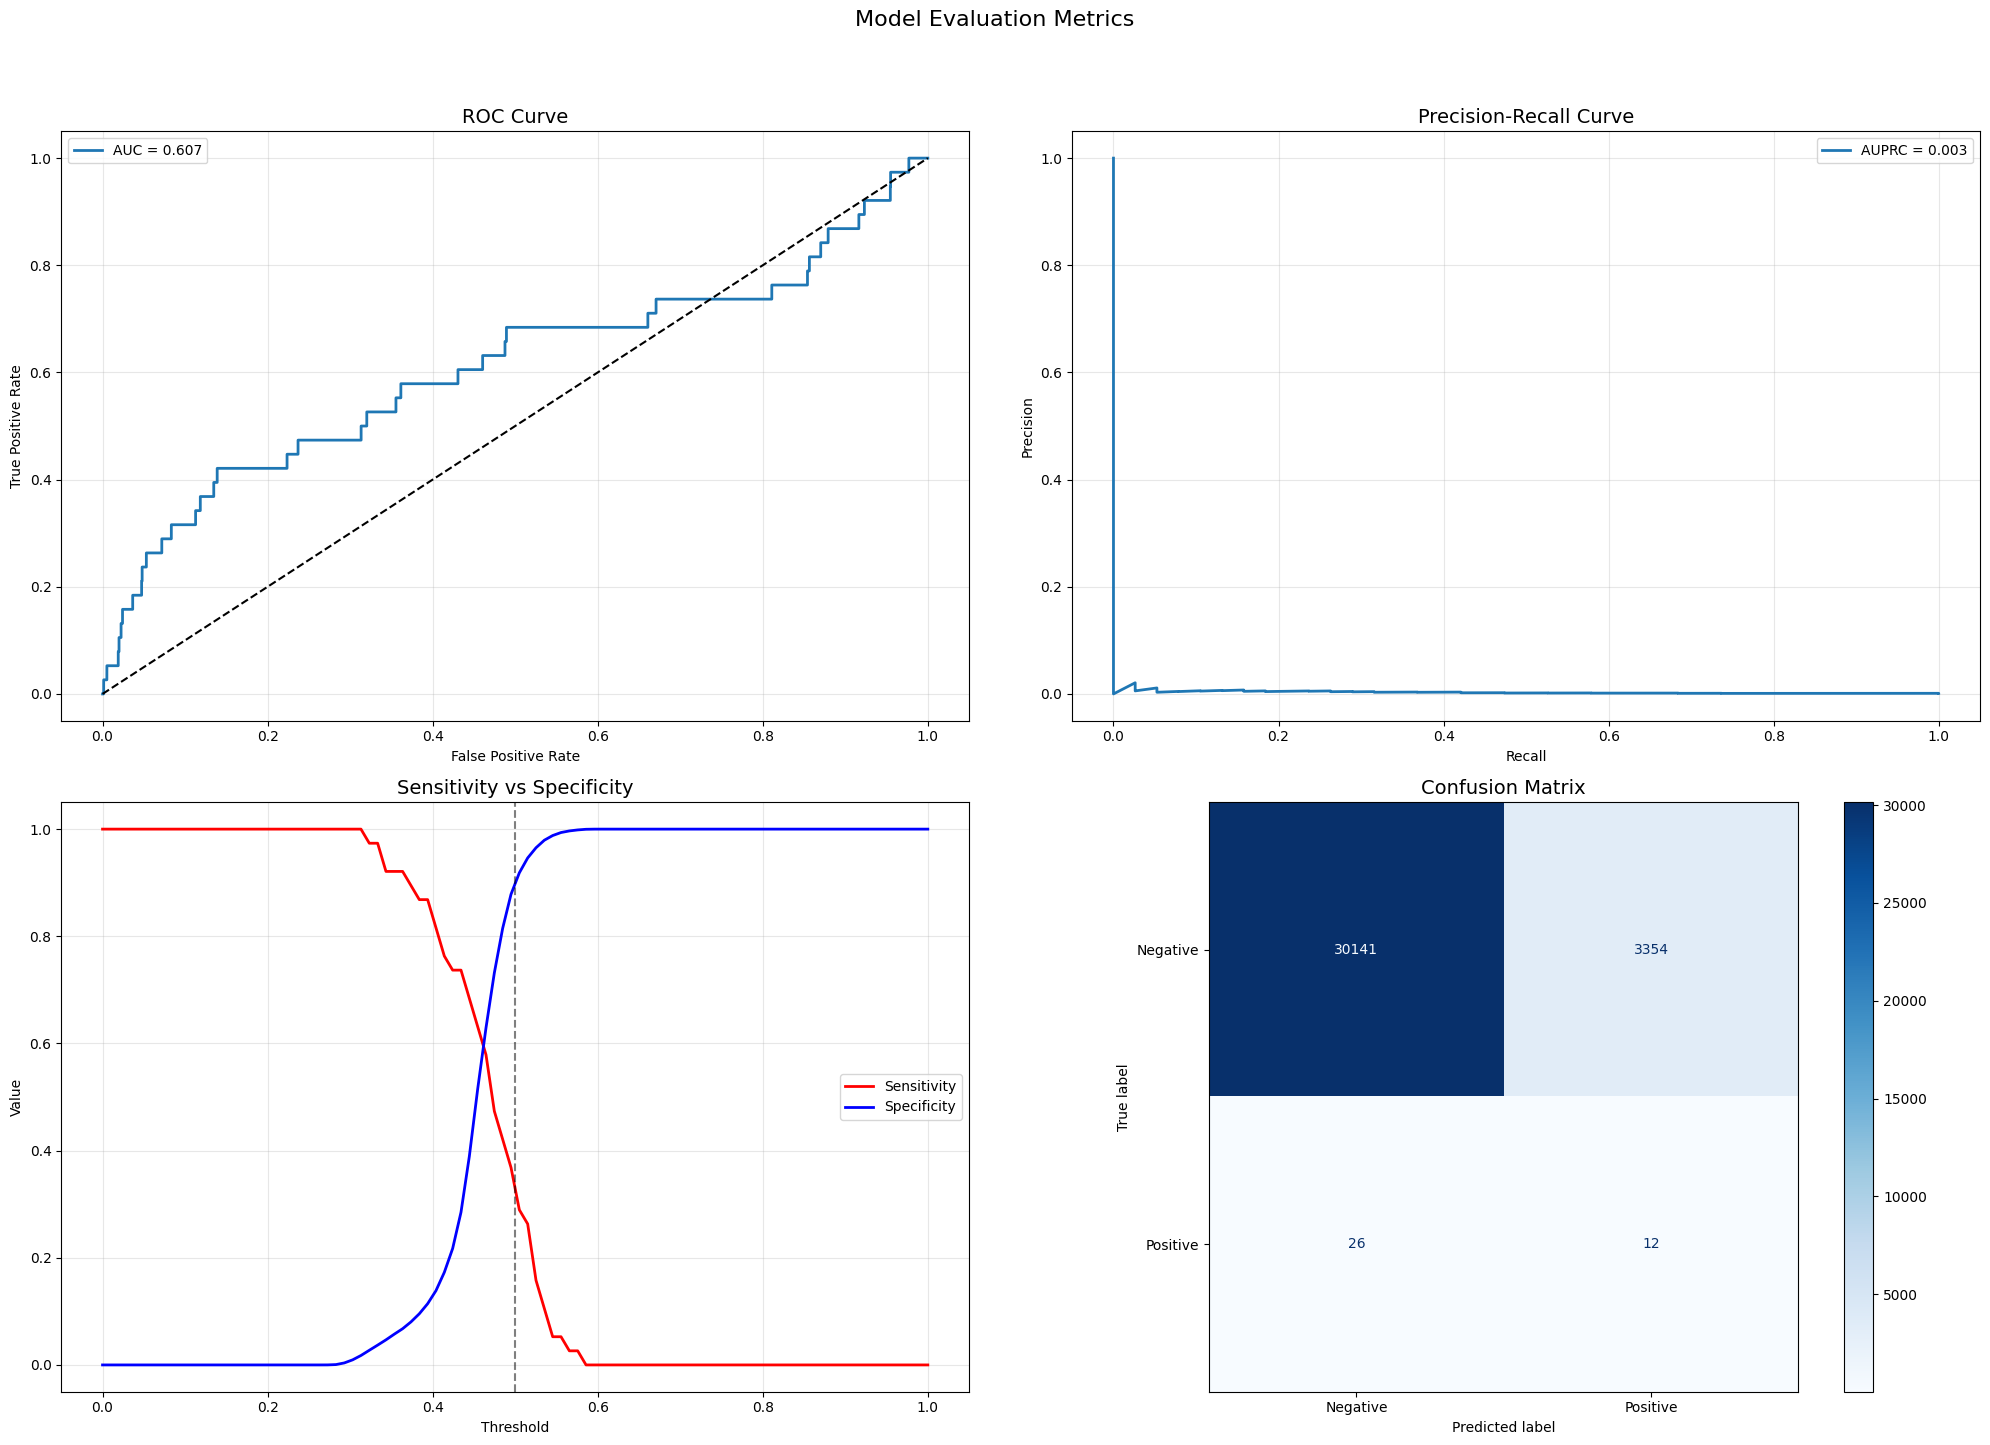

In [0]:
## Plotting against the valid data 

threshold = 0.5

# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 16))

# 1. ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_true, y_prob)
ax1 = plt.subplot(2, 2, 1)
ax1.plot(fpr, tpr, linewidth=2, label=f'AUC = {auc:.3f}')  # auc should be calculated from your evaluator
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve', fontsize=14)
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Precision-Recall Curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_true, y_prob)
ax2 = plt.subplot(2, 2, 2)
ax2.plot(recall_curve, precision_curve, linewidth=2, label=f'AUPRC = {auprc:.3f}')  # auprc from evaluator
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve', fontsize=14)
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Sensitivity vs Specificity at different thresholds
thresholds_range = np.linspace(0, 1, 100)
sensitivity = []
specificity = []

for t in thresholds_range:
    y_pred_t = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_t).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity.append(sens)
    specificity.append(spec)

ax3 = plt.subplot(2, 2, 3)
ax3.plot(thresholds_range, sensitivity, 'r-', linewidth=2, label='Sensitivity')
ax3.plot(thresholds_range, specificity, 'b-', linewidth=2, label='Specificity')
ax3.axvline(x=threshold, color='k', linestyle='--', alpha=0.5)
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Value')
ax3.set_title('Sensitivity vs Specificity', fontsize=14)
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ax4 = plt.subplot(2, 2, 4)
# ConfusionMatrixDisplay will plot on the provided axis
disp = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"])
disp.plot(ax=ax4, cmap='Blues', values_format='d')
ax4.set_title('Confusion Matrix', fontsize=14)

plt.suptitle("Model Evaluation Metrics", fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

## Model Performance on Test data


In [0]:
test_prepared.groupBy("label").count().show()


+-----+-----+
|label|count|
+-----+-----+
|    1|  108|
|    0|45163|
+-----+-----+



In [0]:
# Find number of drop features 
print(f"Number of features dropped: {len(zero_importance)}")
print(f"Number of original features: {len(feature_cols)}")

Number of features dropped: 26
Number of original features: 140


In [0]:
## Evaluate on valid data 
test_prepared_reduced = test_prepared.drop(*zero_importance)
test_predictions = best_rf_model.transform(test_prepared_reduced)

# Set up evaluation metrics

# AUC evaluator (area under ROC)
auc_evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderROC"
)

# AUPRC evaluator (area under PR)
auprc_evaluator = BinaryClassificationEvaluator(
    labelCol="label", 
    rawPredictionCol="rawPrediction", 
    metricName="areaUnderPR"
)

# Precision evaluator (weighted precision)
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="weightedPrecision"
)

# Recall evaluator (weighted recall)
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="weightedRecall"
)

# F1 evaluator
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction",
    metricName="f1"
)

# Evaluate the predictions
auc = auc_evaluator.evaluate(test_predictions)
auprc = auprc_evaluator.evaluate(test_predictions)
precision = precision_evaluator.evaluate(test_predictions)
recall = recall_evaluator.evaluate(test_predictions)
f1 = f1_evaluator.evaluate(test_predictions)

# Print the evaluation metrics
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("AUC:")
print(auc)
print("AUPRC:")
print(auprc)


Precision: 0.9953505850102431
Recall: 0.8716175918358331
F1 Score: 0.9291692479458519
AUC:
0.5452227159072367
AUPRC:
0.002755771125690916


In [0]:
metrics = test_predictions.select(
    sum(when(col("prediction") == 1.0, 1).otherwise(0)).alias("predicted_positives"),
    sum(when(col("label") == 1.0, 1).otherwise(0)).alias("actual_positives"),
    sum(when((col("prediction") == 1.0) & (col("label") == 1.0), 1).otherwise(0)).alias("true_positives"),
    sum(when((col("prediction") == 1.0) & (col("label") == 0.0), 1).otherwise(0)).alias("false_positives"),
    sum(when((col("prediction") == 0.0) & (col("label") == 0.0), 1).otherwise(0)).alias("true_negatives"),
    sum(when((col("prediction") == 0.0) & (col("label") == 1.0), 1).otherwise(0)).alias("false_negatives")
).collect()[0]

# Extract values from the Row
predicted_positives = metrics.predicted_positives
actual_positives = metrics.actual_positives
actual_negatives = valid_predictions.count() - actual_positives
true_positives = metrics.true_positives
false_positives = metrics.false_positives
true_negatives = metrics.true_negatives
false_negatives = metrics.false_negatives

# Calculate TPR, FPR, and PPV
tpr = float(true_positives) / float(actual_positives) if actual_positives > 0 else 0.0
fpr = float(false_positives) / float(actual_negatives) if actual_negatives > 0 else 0.0
ppv = float(true_positives) / float(predicted_positives) if predicted_positives > 0 else 0.0

print(f"True Positives Rate: {tpr}")
print(f"False Positive Rate: {fpr}")
print(f"Positive Predictive Value: {ppv}")

True Positives Rate: 0.16666666666666666
False Positive Rate: 0.171189229618549
Positive Predictive Value: 0.0031358885017421603


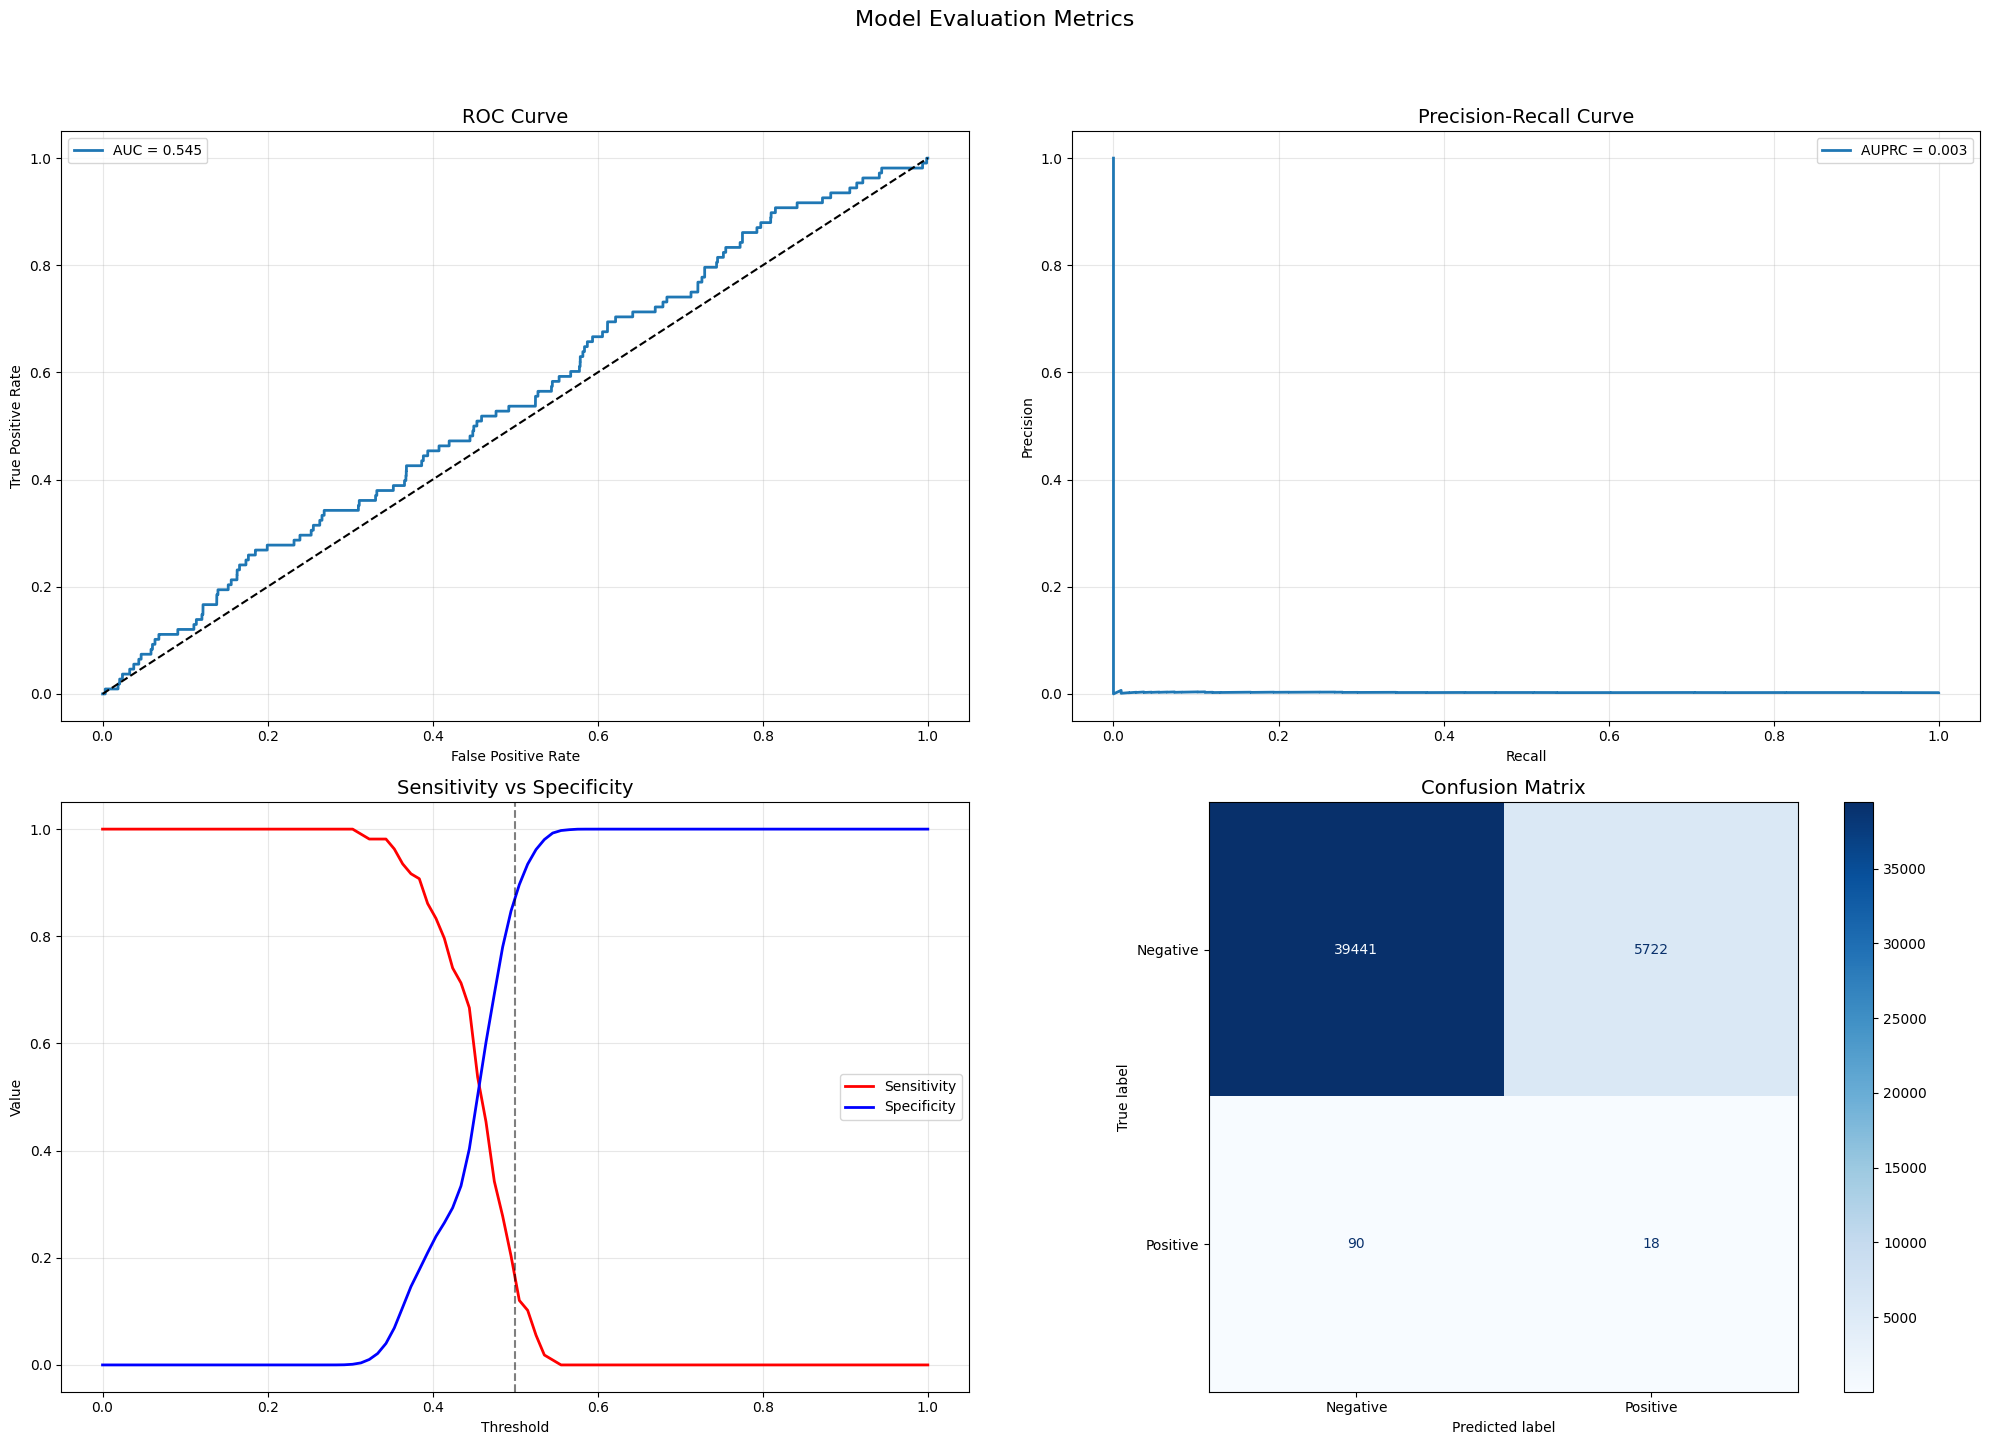

In [0]:
def extract_positive_prob(probability_vector):
    return float(probability_vector[1])

extract_positive_prob_udf = udf(extract_positive_prob, DoubleType())

# Use the UDF to create the 'probability_pos' column and convert the Spark DataFrame to Pandas
pandas_df = test_predictions.select(
    col("label").cast("double").alias("label"),
    col("prediction").cast("double").alias("prediction"),
    extract_positive_prob_udf(col("probability")).alias("probability_pos")
).toPandas()


# Get data for calculations
y_true = pandas_df["label"].values
y_pred = pandas_df["prediction"].values
y_prob = pandas_df["probability_pos"].values

## Plotting against the valid data 

threshold = 0.5

# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 16))

# 1. ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_true, y_prob)
ax1 = plt.subplot(2, 2, 1)
ax1.plot(fpr, tpr, linewidth=2, label=f'AUC = {auc:.3f}')  # auc should be calculated from your evaluator
ax1.plot([0, 1], [0, 1], 'k--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve', fontsize=14)
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Precision-Recall Curve
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_true, y_prob)
ax2 = plt.subplot(2, 2, 2)
ax2.plot(recall_curve, precision_curve, linewidth=2, label=f'AUPRC = {auprc:.3f}')  # auprc from evaluator
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve', fontsize=14)
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Sensitivity vs Specificity at different thresholds
thresholds_range = np.linspace(0, 1, 100)
sensitivity = []
specificity = []

for t in thresholds_range:
    y_pred_t = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_t).ravel()
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity.append(sens)
    specificity.append(spec)

ax3 = plt.subplot(2, 2, 3)
ax3.plot(thresholds_range, sensitivity, 'r-', linewidth=2, label='Sensitivity')
ax3.plot(thresholds_range, specificity, 'b-', linewidth=2, label='Specificity')
ax3.axvline(x=threshold, color='k', linestyle='--', alpha=0.5)
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Value')
ax3.set_title('Sensitivity vs Specificity', fontsize=14)
ax3.legend()
ax3.grid(alpha=0.3)

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ax4 = plt.subplot(2, 2, 4)
# ConfusionMatrixDisplay will plot on the provided axis
disp = ConfusionMatrixDisplay(cm, display_labels=["Negative", "Positive"])
disp.plot(ax=ax4, cmap='Blues', values_format='d')
ax4.set_title('Confusion Matrix', fontsize=14)

plt.suptitle("Model Evaluation Metrics", fontsize=16, y=0.98)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()
    

**Observation**: 
- An AUC of 0.5452 is only slightly above random (0.5), suggesting the model provides minimal discrimination between accidents and non-accidents overall. The AUPRC of 0.00276 is extremely low, reflecting the difficulty of achieving both high precision and high recall on the minority class in such an imbalanced dataset.
- TPR (True Positive Rate) = 0.167 means the model only catches about 16.7% of the real accidents at the chosen threshold.
- FPR (False Positive Rate) = 0.171 is the fraction of non-accidents that get classified as accidents. Because you likely have many more negative (non-accident) example. I am also missing the majority of real accidents (83% go undetected) while also tagging a sizable fraction of non-accidents as accidents. 
- There are still a lot of overfitting in the dominant negative class; The tiny AUPRC, modest AUC, and low TPR indicate the model is not doing a strong job at identifying real accidents

In [0]:
# save test prediction 
test_predictions.write.format("parquet").save("dbfs:/FileStore/tables/best_model_test_predictions")

# Save model 
best_rf_model.save("best_rf_model")